# Imports 

In [ ]:
!pip install lime
!pip install spacy_langdetect
!pip install scattertext

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline

from wordcloud import WordCloud
import spacy
from spacy_langdetect import LanguageDetector

import scattertext as st


In [ ]:
import nltk
from nltk import word_tokenize
nltk.download('punkt')

# Data 

In [ ]:
!python get_data.py

In [ ]:
data = pd.read_csv("./Data/Reviews_Short_Sentiment.csv",index_col=0).reset_index(drop=True)

In [ ]:
data.head()

,reviews,sentiment,site
0,So there is no way for me to plug it in here i...,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more...,0,amazon
4,The mic is great.,1,amazon


In [ ]:
data.shape

(2748, 3)

In [ ]:
data.dtypes

reviews      object
sentiment     int64
site         object
dtype: object

In [ ]:
data.isna().sum()

reviews      0
sentiment    0
site         0
dtype: int64

# Preliminary EDA

__Check if the data is balanced (it is, as designed by the creator of this dataset)__

In [ ]:
data.groupby(['site','sentiment']).size()

site    sentiment
amazon  0            500
        1            500
imdb    0            500
        1            500
yelp    0            362
        1            386
dtype: int64

__Plot WordCluds of All Words, Words in Postive Reviews and Words in Negative Reviews for each site__

Text(0.5, 1.0, 'Imdb')

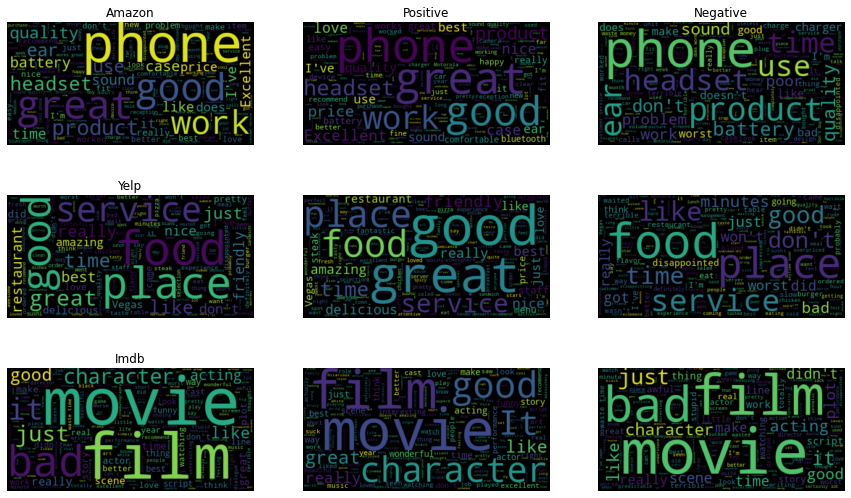

In [ ]:
fig,axes = plt.subplots(3,3,figsize=(15,9))

companies = ['amazon','yelp','imdb']

for company,ax in zip(companies,axes):

  filtered_data = data[data.site==company]
  
  word_string_full = " ".join(filtered_data.reviews.to_list())
  word_string_pos = " ".join(filtered_data[filtered_data.sentiment == 1].reviews.to_list())
  word_string_neg = " ".join(filtered_data[filtered_data.sentiment == 0].reviews.to_list())

  list_of_strings = [word_string_full,word_string_pos,word_string_neg]

  for i, string in enumerate(list_of_strings):

    cloud = WordCloud(background_color='black',stopwords=ENGLISH_STOP_WORDS).generate(string)
    ax[i].imshow(cloud,interpolation='bilinear')
    ax[i].axis('off')

axes[0,0].set_title('Amazon')
axes[0,1].set_title('Positive')
axes[0,2].set_title('Negative')
axes[1,0].set_title('Yelp')
axes[2,0].set_title('Imdb')



Discussion: Movie,film,phone,service clearly need to be removed because of their frequency and relatively little distinguishing power they have between sentiment. 

__Plot Words using scattertext__

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
temp = data.copy()
temp.sentiment = temp.sentiment.replace({1:'Positive',0:'Negative'})

corpus = st.CorpusFromPandas(temp,
                             category_col="sentiment",
                             text_col="reviews",
                             nlp=nlp).build()

In [ ]:
html = st.produce_scattertext_explorer(
    corpus,
    category="Positive",
    category_name="Positive",
    not_category_name="Negative",
    width_in_pixels=1000,
    metadata = temp['site']
    
)

In [ ]:
from IPython.display import IFrame
from IPython.core.display import display, HTML


display(HTML("<style>.container { width:98% !important; }</style>"))
display(HTML(html))

__Check for any non-enlish reviews__

In [ ]:
nlp = spacy.load('en')  
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True) 

text = " ".join(data.reviews.to_list())
doc = nlp(text)

print(doc._.language)

{'language': 'en', 'score': 0.9999952482601497}


# Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.reviews,data.sentiment,test_size=.2) 

# Feature Engineering

Use a TFIDF to featureize the documents

Note: Since the dataset is small and different arguments will be test later, no regularization is used in either (i.e. no limitation of the number of features)


## TFIDF

In [ ]:
stopwords = ENGLISH_STOP_WORDS.union({'movie','film','movie','phone'})

In [ ]:
# Build the vectorizer, specify max features and fit
vect_tf = TfidfVectorizer(stop_words=stopwords)
vect_tf.fit(X_train)

# Transform the review
X_train_tfidf = vect_tf.transform(X_train)

In [ ]:
X_train_tfidf.shape

(2198, 4311)

In [ ]:
# Quick View
tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=vect_tf.get_feature_names())
print(tfidf_df.head())

    00        10  100   11   12  ...  z500a  zero  zillion  zombie  zombiez
0  0.0  0.000000  0.0  0.0  0.0  ...    0.0   0.0      0.0     0.0      0.0
1  0.0  0.000000  0.0  0.0  0.0  ...    0.0   0.0      0.0     0.0      0.0
2  0.0  0.000000  0.0  0.0  0.0  ...    0.0   0.0      0.0     0.0      0.0
3  0.0  0.842551  0.0  0.0  0.0  ...    0.0   0.0      0.0     0.0      0.0
4  0.0  0.000000  0.0  0.0  0.0  ...    0.0   0.0      0.0     0.0      0.0

[5 rows x 4311 columns]


# Feature Selection

Perform Univariate Chi2 Test to determine which featues have highest score. The higher the score the more the difference in label counts is unlikely to be random.

Preliminarily, keeping top 75% of the features. This number will decrease when including bigrams later

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

In [ ]:
X_train_tfidf.shape

(2198, 4311)

In [ ]:
#Perform Test

num_features = round(X_train_tfidf.shape[1]*.75)

test = SelectKBest(score_func=chi2, k=num_features)
test.fit(X_train_tfidf, y_train)

SelectKBest(k=3233, score_func=<function chi2 at 0x7f207a8340e0>)

In [ ]:
features_df = pd.DataFrame({"features":vect_tf.get_feature_names(),"score":test.scores_}).sort_values("score",ascending=False)
features_df.head(10)

,features,score
1691,great,45.843183
299,bad,22.118521
1664,good,16.766567
2286,love,14.378359
4264,works,14.231795
1338,excellent,14.025638
4171,waste,13.021616
2542,nice,10.815154
4269,worst,10.711876
3799,terrible,10.515133


In [ ]:
# Update the training data

X_tfidf_train_red = test.transform(X_train_tfidf)

In [ ]:
X_tfidf_train_red.shape

(2198, 3233)

# Compare Three Simple Models 

Note: 
* Using default paramaters initially, again, because they will be chosen later in a grid search
* Have to transform test data

In [ ]:
X_test_tfidf = vect_tf.transform(X_test)
X_test_tfidf_red = test.transform(X_test_tfidf)

In [ ]:
for model in [SGDClassifier,LogisticRegression,MultinomialNB]:

 
  mod = model().fit(X_tfidf_train_red,y_train)

  predictions = mod.predict(X_test_tfidf_red)

  print("="*20)

  print(model.__name__,'\n')
  print('Accuracy on the test set: ', accuracy_score(y_test, predictions))
  print('Confusion Matrix: ','\n',confusion_matrix(y_test, predictions))

SGDClassifier 

Accuracy on the test set:  0.8163636363636364
Confusion Matrix:  
 [[235  45]
 [ 56 214]]
LogisticRegression 

Accuracy on the test set:  0.8090909090909091
Confusion Matrix:  
 [[234  46]
 [ 59 211]]
MultinomialNB 

Accuracy on the test set:  0.7981818181818182
Confusion Matrix:  
 [[212  68]
 [ 43 227]]


# Optimize Transformation Pipeline

In [ ]:
# Paramaters to test across 

para_grid= [{
    'transform__tfidf__use_idf':[True,False],
    'transform__chi2_red__k':[1000,2000,3000,3500]

},
            {          
    'transform__tfidf__use_idf':[True,False],           
    'transform__tfidf__ngram_range':[(1,2),(1,3)],
    'transform__chi2_red__k':[1000,2000,3000,5000,10000]}]

In [ ]:
transf_pipe = Pipeline([('tfidf',TfidfVectorizer(stop_words=stopwords)),
                 ('chi2_red', SelectKBest(score_func=chi2))
                        
])

In [ ]:
for model in [SGDClassifier,LogisticRegression,MultinomialNB]:

  pipe= Pipeline([
                  ('transform',transf_pipe),
                  ('clf',model())])
  
  pipe_gs = sklearn.model_selection.GridSearchCV(pipe,para_grid)

  pipe_gs.fit(X_train,y_train)

  predictions = pipe_gs.predict(X_test)
  
  best_models.append((model.__name__,pipe_gs.best_params_))

  print("="*20)
  print(model.__name__,'\n')
  print(pipe_gs.best_params_)
  print('Accuracy on the test set: ', accuracy_score(y_test, predictions))
  print('Confusion Matrix: ','\n',confusion_matrix(y_test, predictions))


SGDClassifier 

{'transform__chi2_red__k': 10000, 'transform__tfidf__ngram_range': (1, 2), 'transform__tfidf__use_idf': True}
Accuracy on the test set:  0.8163636363636364
Confusion Matrix:  
 [[232  48]
 [ 53 217]]
LogisticRegression 

{'transform__chi2_red__k': 5000, 'transform__tfidf__ngram_range': (1, 2), 'transform__tfidf__use_idf': True}
Accuracy on the test set:  0.7981818181818182
Confusion Matrix:  
 [[236  44]
 [ 67 203]]
MultinomialNB 

{'transform__chi2_red__k': 10000, 'transform__tfidf__ngram_range': (1, 2), 'transform__tfidf__use_idf': True}
Accuracy on the test set:  0.8
Confusion Matrix:  
 [[207  73]
 [ 37 233]]


# Grid Search on SVC Classifier

The transformation pipeline is currently fitted with the optimal values

In [ ]:
transf_best = pipe_gs.best_estimator_['transform']

In [ ]:
X_train_final = transf_best.transform(X_train)
X_test_final = transf_best.transform(X_test)

In [ ]:
param_grid = {'alpha': [0.0001, 0.001, .01, .1, 1]}

grid = GridSearchCV(SGDClassifier(), param_grid)

grid.fit(X_train_final,y_train)

In [ ]:
preds = grid.predict(X_test_final)
print('Accuracy on the test set: ', accuracy_score(y_test, preds))
print('Confusion Matrix: ','\n',confusion_matrix(y_test, preds))

Accuracy on the test set:  0.8163636363636364
Confusion Matrix:  
 [[233  47]
 [ 54 216]]


In [ ]:
grid.best_params_

{'alpha': 0.0001}